# Google Colab extension

In [1]:
!nvidia-smi

Fri Feb 20 21:54:00 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
print(f"Is CUDA available? {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")

Is CUDA available? True
Current GPU: Tesla T4


In [ ]:
#!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip install pyvirtualdisplay
!pip install pyglet==1.5.1
#!pip install ple

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.16).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.3 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement ple (from versions: none)
ERROR: No matching distribution found for ple


In [5]:
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [6]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gymnasium as gym
#import gym_pygame  # use CartPole instead
import imageio

## 1. Helper modules and functions

In [15]:
class Policy(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size) # 4 * h
        self.fc2 = nn.Linear(hidden_size, action_size) # h * 2 

    def forward(self, x):
        x = F.relu(self.fc1(x)) # active the fc1 with relu
        x = self.fc2(x)  # pass to fc2
        return F.softmax(x, dim=1) # probability

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device) # transfer state to tensor
        probs = self.forward(state) # get the probability
        m = Categorical(probs)
        action = m.sample() # sampling based on prob (Gaussian)
        return action.item(), m.log_prob(action)

In [35]:
# THE STANDARD REINFORCE !!!
def reinforce(policy, env, n_training_episodes, max_t, gamma, optimizer, print_every):
        
    scores_deque = deque(maxlen=100)
    scores = []

    # Unlike DQN, REINFORCE updates the reward until one episode ended
    for i_episode in range(1, n_training_episodes+1):

        saved_log_probs = []
        state, info = env.reset()
        rewards = []

        # Recording the trajectory (0--->T)
        for t in range(max_t): # do not be stuck too long
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, terminated, truncated, _ = env.step(action)
            rewards.append(reward)  
            if terminated or truncated:
                break
        
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards)) 
        returns = deque(maxlen=max_t)

        # discount return:  Gt = Rt + gamma*R(t+1) + gamma^2*R(t+2) + ...
        #                   Gt = Rt + gamma*G(T+1), MD , (T--->0)
        n_steps = len(rewards) 
        for t in range(n_steps)[::-1]: # start from the last one
            disc_return_t = returns[0] if len(returns) > 0 else 0
            # append left -> mask sure the the time sequence 
            returns.appendleft(gamma * disc_return_t + rewards[t])

        # safty buffer  
        eps = np.finfo(np.float32).eps.item() # 1.19e-7. smaller enough
        returns = torch.tensor(returns)
        # get the relative reward
        returns = (returns-returns.mean()) / (returns.std()+eps)  # it's safe even the returns.std() is 0

        # well, the 'loss' is not the diff between expected and real rewards, it's the minus Performance Objective Function -J(theta) instead.
        # the policy-based method using gradiant ascent to maximize the J(theta) while pyTorch and TF using gradiant descent.  
        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)
        # The final -J(theta) !!!       
        policy_loss = torch.cat(policy_loss).sum()

        optimizer.zero_grad()  # renew
        policy_loss.backward() # partial J(theta)
        optimizer.step()  # theta_new = theta_old - lr * gradient
        print(f"What do you have in your brain/mind? {policy.fc1.weight.grad}")


        if i_episode % print_every == 0:
            print("Episode {}\tAverage Score: {:.2f}".format(i_episode, np.mean(scores_deque)))
        
    return scores

## 2. set the env and load policy

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
env_id = "CartPole-v1"
env = gym.make(env_id)
eval_env = gym.make(env_id)

# Get the state space and action space
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [12]:
lr = 0.01

In [18]:
cartpole_policy = Policy(
    state_size, action_size, hidden_size=16
).to(device)

cartpole_optimizer = optim.Adam(cartpole_policy.parameters(), lr=lr)

## 3. training

In [ ]:
scores = reinforce(
    env = gym.make("CartPole-v1"),
    policy = cartpole_policy,
    n_training_episodes = 1000, 
    max_t = 1000,
    gamma = 1.0,
    optimizer = cartpole_optimizer,
    print_every = 100
)

What do you have in your brain/mind? tensor([[ 0.0000e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 2.3828e-02,  9.8309e-02, -7.7379e-02, -2.5172e-01],
        [-6.5281e-03, -1.1391e-01,  3.2770e-02,  1.9864e-01],
        [-1.9779e-02,  5.9389e-02, -1.2932e-02, -6.9835e-02],
        [ 2.3514e-02, -1.5973e-01,  3.0245e-03,  1.9805e-01],
        [-9.5445e-04,  6.4838e-03, -1.2277e-04, -8.0390e-03],
        [ 1.2936e-02, -5.5235e-02, -3.5406e-03,  5.8122e-02],
        [ 1.3839e-02, -9.4009e-02,  1.7800e-03,  1.1656e-01],
        [ 0.0000e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 2.2068e-02, -1.4991e-01,  2.8385e-03,  1.8587e-01],
        [ 4.6857e-02, -3.1831e-01,  6.0271e-03,  3.9466e-01],
        [ 8.6016e-03, -7.1643e-02,  1.0537e-02,  1.0090e-01],
        [ 2.0861e-02, -1.4171e-01,  2.6833e-03,  1.7570e-01],
        [ 0.0000e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 2.2504e-03, -2.3126e-03,  1.4471e-03,  1.1059e-03],
        [ 5.4446e-06, -3.0319e-04

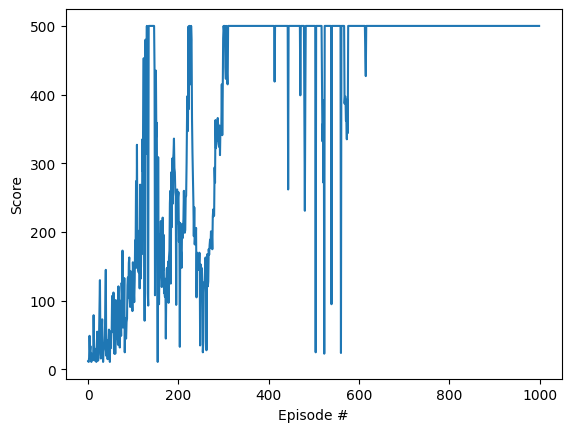

In [27]:
import matplotlib.pyplot as plt

plt.plot(scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 4. evaluation

In [31]:
episode_rewards = []

def evaluate_agent(env, max_steps, n_eval_episodes, policy):

    state, info = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0

    for episode in range(n_eval_episodes):
        for step in range(max_steps):
            action, _ = policy.act(state)
            new_state, reward, terminated, truncated, info = env.step(action)
            total_rewards_ep += reward
            if done:
                break
            state = new_state

        episode_rewards.append(total_rewards_ep)
    mean_reward = np.mean(episode_rewards) # calculate for each episode !!!
    std_reward = np.std(episode_rewards)
    return mean_reward, std_reward

In [32]:
evaluate_agent(
    eval_env, 10, 10, cartpole_policy
)

(np.float64(500500.0), np.float64(288674.9902572095))

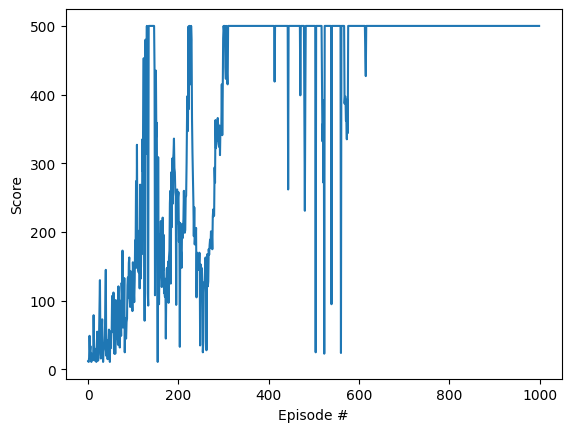

In [34]:
import matplotlib.pyplot as plt

plt.plot(scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# LET'S RELOAD LUNARLANDER !!! 

In [38]:
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 54.1 MB/s eta 0:00:00a 0:00:01


In [39]:
lunar_policy = Policy(state_size=8, action_size=4, hidden_size=128).to(device)
lunar_optimizer = optim.Adam(lunar_policy.parameters(), lr=1e-3)

scores = reinforce(
    env = gym.make("LunarLander-v3"),
    policy = lunar_policy,
    n_training_episodes = 2000, 
    max_t = 1000,
    gamma = 0.99,
    optimizer = lunar_optimizer,
    print_every = 100
)

What do you have in your brain/mind? tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0480, -0.0036, -0.0665,  ..., -0.0804, -0.1069, -0.1069],
        [ 0.0396,  0.3751,  0.1271,  ..., -0.0435,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')
What do you have in your brain/mind? tensor([[-0.0691, -0.1073, -0.0584,  ..., -0.0273,  0.0000,  0.0000],
        [-0.1179, -0.6429,  0.1070,  ..., -0.0742,  0.0000,  0.0000],
        [ 0.0204, -0.0371,  0.0467,  ..., -0.0259,  0.0000,  0.0000],
        ...,
        [ 0.5023,  0.0664,  0.7496,  ..., -0.2797,  0.0000,  0.0000],
        [ 0.0336, -0.5745,  0.3066,  ..., -0.1117,  0.0000,  0.0000],
        [-0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')
What do yo

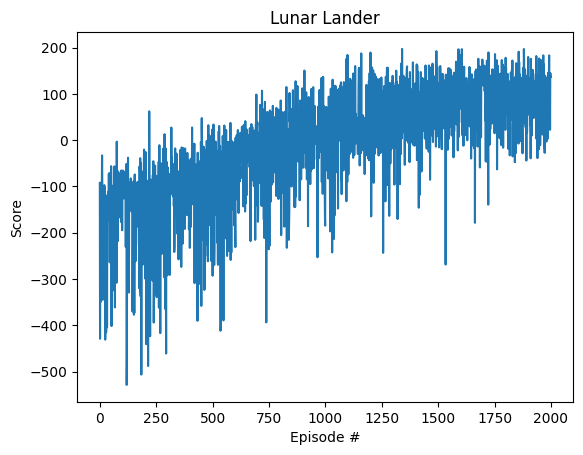

In [40]:
import matplotlib.pyplot as plt

plt.plot(scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Lunar Lander')
plt.show()